In [3]:
#Import Modules
import datacube
import datetime
import fiona
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio.mask
import rasterio.features
from shapely import geometry
import seaborn as sns
import sys
import xarray as xr

import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

from datacube.storage import masking
from datacube.utils import geometry
from datacube.helpers import ga_pq_fuser, write_geotiff
from datacube.helpers import write_geotiff

sys.path.append('/g/data/u46/users/ck9738/10_Scripts')
import TasseledCapTools
#import DEADataHandling

dc = datacube.Datacube(app='tcw')

%load_ext autoreload

%autoreload 2

In [4]:
help(write_geotiff)

Help on function write_geotiff in module datacube.helpers:

write_geotiff(filename, dataset, profile_override=None, time_index=None)
    Write an ODC style xarray.Dataset to a GeoTIFF file.
    
    :param filename: Output filename
    :param dataset: xarray dataset containing one or more bands to write to a file.
    :param profile_override: option dict, overrides rasterio file creation options.
    :param time_index: DEPRECATED



In [5]:
#define area of interest
query = {
    
# #ever lasting swamp
# 'y': (-29.365, -29.489),
# 'x': (153.033, 153.200),
    
    
#lake Coleman
# 'y': (-38.103, -38.259),
# 'x': (147.098, 147.421),
    
     #Macquarie Marshes
'y': (-30.512, -30.977),
'x': (147.413, 147.809),
    
    #Big Gunbower
# 'y': (-35.636, -35.905),
# 'x': (144.102, 144.387),
    
# jerrabombera wetland
#'y': (-35.288, -35.346),
#'x': (149.139, 149.191),

#ACT
# 'y': (-35.270, -35.336),
# 'x': (149.021, 149.194),    

    #lake george
# 'y': (-34.957, -35.221),
# 'x': (149.294, 149.519),   
    
#Kowen
# 'y': (-35.269, -35.354),
# 'x': (149.239, 149.396),   
    
#gunbower
# 'y': (-35.743, -35.909),
# 'x': (144.235, 144.387),
    
    
'time': ('2018-01-01', '2018-12-30'),
'crs': 'EPSG:4326',
'output_crs': 'EPSG: 3577',
'resolution': (-25, 25)
}
    

In [6]:
#load data
data_lst8 = dc.load(product='ls8_nbart_albers', group_by='solar_day', **query)
data_lst8

<xarray.Dataset>
Dimensions:          (time: 45, x: 1140, y: 1289)
Coordinates:
  * time             (time) datetime64[ns] 2018-01-07T00:15:07.500000 ... 2018-12-25T00:14:53
  * y                (y) float64 -3.945e+06 -3.945e+06 ... -3.977e+06 -3.977e+06
  * x                (x) float64 1.091e+06 1.091e+06 ... 1.119e+06 1.119e+06
Data variables:
    coastal_aerosol  (time, y, x) int16 503 491 491 492 ... -999 -999 -999 -999
    blue             (time, y, x) int16 544 541 538 537 ... -999 -999 -999 -999
    green            (time, y, x) int16 846 852 854 855 ... -999 -999 -999 -999
    red              (time, y, x) int16 1109 1116 1108 1105 ... -999 -999 -999
    nir              (time, y, x) int16 2590 2621 2641 2660 ... -999 -999 -999
    swir1            (time, y, x) int16 2940 2953 2943 2934 ... -999 -999 -999
    swir2            (time, y, x) int16 1810 1798 1788 1769 ... -999 -999 -999
Attributes:
    crs:      EPSG: 3577

In [7]:
#define number of total observations

total_obs = int(len(data_lst8.time))
total_obs

45

In [8]:
#load PG
sensor_pq = dc.load(product='ls8_pq_albers', fuse_func=ga_pq_fuser, group_by='solar_day', **query)
sensor_pq

<xarray.Dataset>
Dimensions:       (time: 45, x: 1140, y: 1289)
Coordinates:
  * time          (time) datetime64[ns] 2018-01-07T00:15:07.500000 ... 2018-12-25T00:14:53
  * y             (y) float64 -3.945e+06 -3.945e+06 ... -3.977e+06 -3.977e+06
  * x             (x) float64 1.091e+06 1.091e+06 ... 1.119e+06 1.119e+06
Data variables:
    pixelquality  (time, y, x) int16 16383 16383 16383 ... 16127 16127 16127
Attributes:
    crs:      EPSG: 3577

In [9]:
#Mask Cloud

#make Mask
good_quality = masking.make_mask(sensor_pq.pixelquality,
                                 cloud_acca='no_cloud',
                                 cloud_fmask='no_cloud',
                                 cloud_shadow_acca='no_cloud_shadow',
                                 cloud_shadow_fmask='no_cloud_shadow',
                                 blue_saturated=False,
                                 green_saturated=False,
                                 red_saturated=False,
                                 nir_saturated=False,
                                 swir1_saturated=False,
                                 swir2_saturated=False,
                                 contiguous=True)
good_quality

<xarray.DataArray 'pixelquality' (time: 45, y: 1289, x: 1140)>
array([[[ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True],
        ...,
        [ True,  True, ..., False, False],
        [ True,  True, ..., False, False]],

       [[ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True],
        ...,
        [ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True]],

       ...,

       [[ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True],
        ...,
        [False, False, ...,  True,  True],
        [False, False, ...,  True,  True]],

       [[ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True],
        ...,
        [ True,  True, ..., False, False],
        [ True,  True, ..., False, False]]])
Coordinates:
  * time     (time) datetime64[ns] 2018-01-07T00:15:07.500000 ... 2018-12-25T00:14:53
  * y        (y) float64 -3.945e+06 -3.945e+06 ... -3.977e+06 -3.977e+06
  * 

In [10]:
#apply Mask
Masked_lst8_data = data_lst8.where(good_quality)


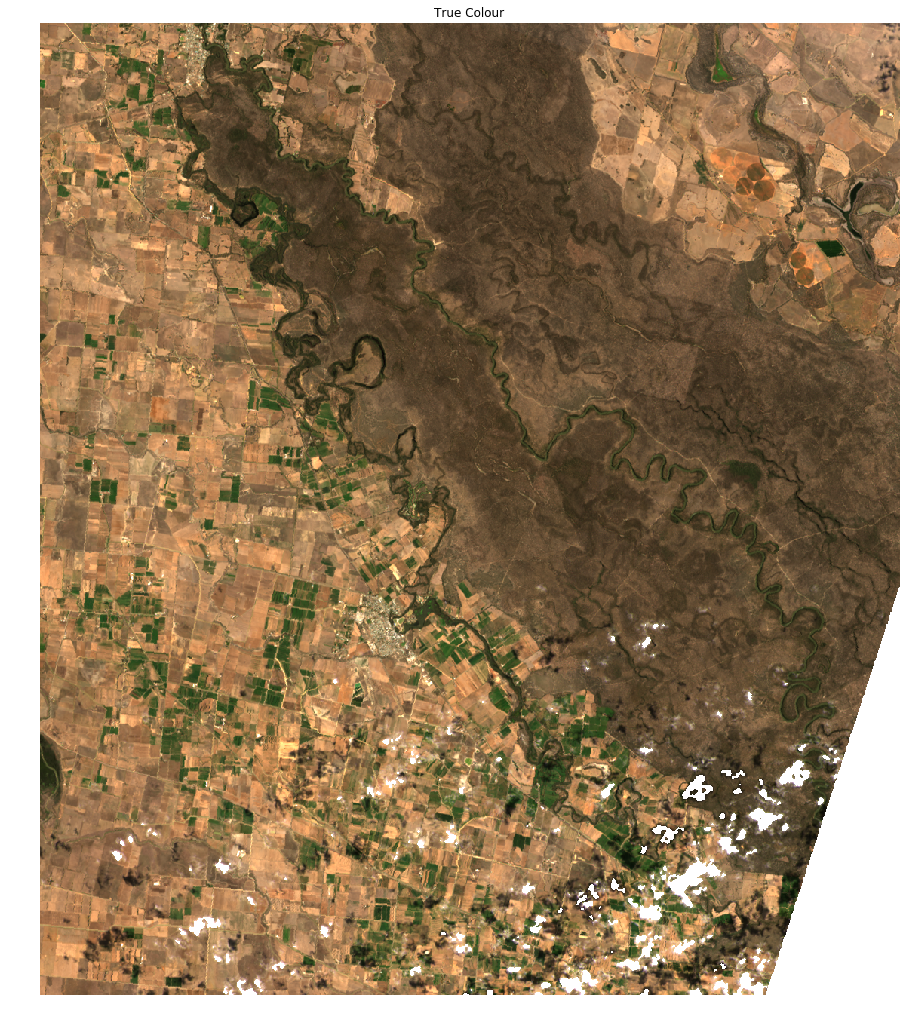

In [11]:
data_lst8_once = Masked_lst8_data.isel(time=2)

#Prepare geomedian imagery for plotting

rgb = data_lst8_once.to_array(dim='color').sel(color=[
    'red','green', 'blue']).transpose('y', 'x', 'color')
fake_saturation = 2000.0  #you may need to adjust this to get a clear image. higher numbers will make it darker, 
                                                                            #lower will make it ligher
rgb = rgb.astype('double')
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

fig = plt.figure(figsize =(15,15)) #edit size of plot 
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05) #set border dimensions
fig.patch.set_facecolor('white') #make border white 
fig.patch.set_alpha(0.99)#ensure border white
plt.axis('off')#remove axis 
plt.title('True Colour') #add title
plt.imshow(scaled, interpolation = 'nearest') #create image

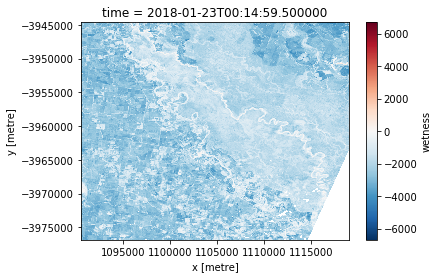

In [12]:
#Do tassled Cap transformation
TCI = TasseledCapTools.thresholded_tasseled_cap(Masked_lst8_data,wetness_threshold=-1200, drop=True
                                                , drop_tc_bands=False)
tcw = TCI['wetness']
tcg = TCI['greenness']
tcb = TCI['brightness']

tcw.isel(time=2).plot()

In [13]:
#Apply wet classification over Data

wet_values = tcw.where(tcw<-350, 1) #first turn everything wet to 1
wet_values = wet_values.where(tcw>=-350,0) #then turn everything dry to 0

In [14]:
#Apply wet classification over Data

wet_not_pine_values = wet_values.where(tcg<1000,0)  #first turn everything wet to 1


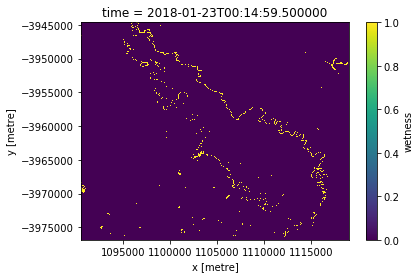

In [15]:
wet_not_pine_values.isel(time=2).plot()

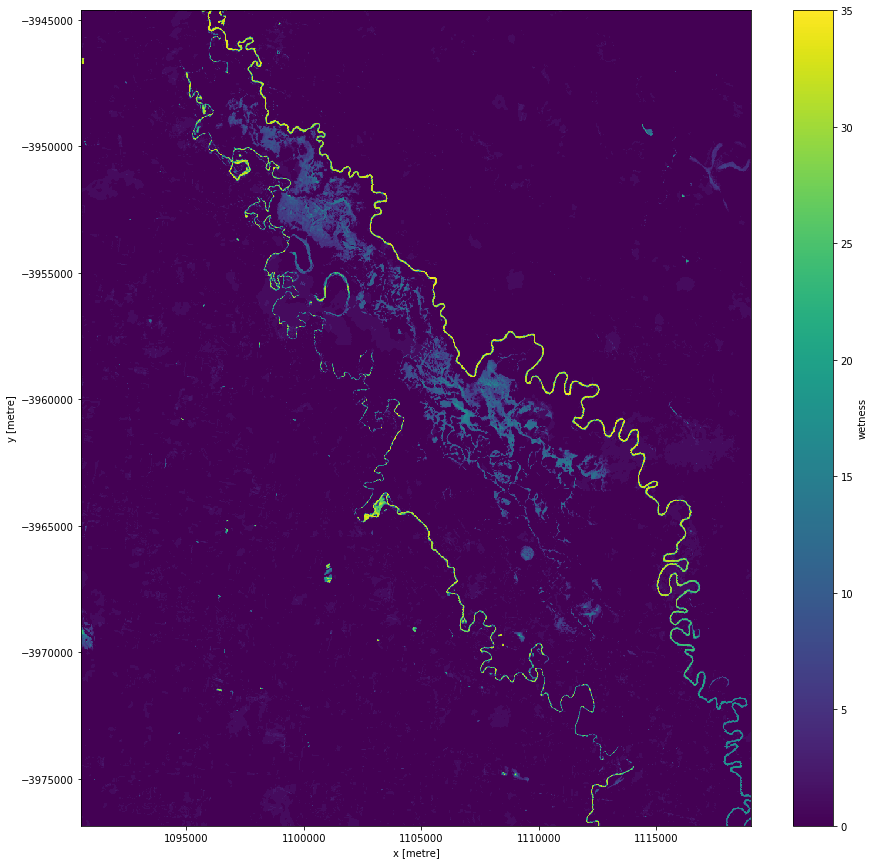

In [16]:
#Combine all date slices to gether to create a wetness frequency

wet_frequency = wet_not_pine_values.sum(dim='time')
wet_frequency.plot(figsize =(15,15))




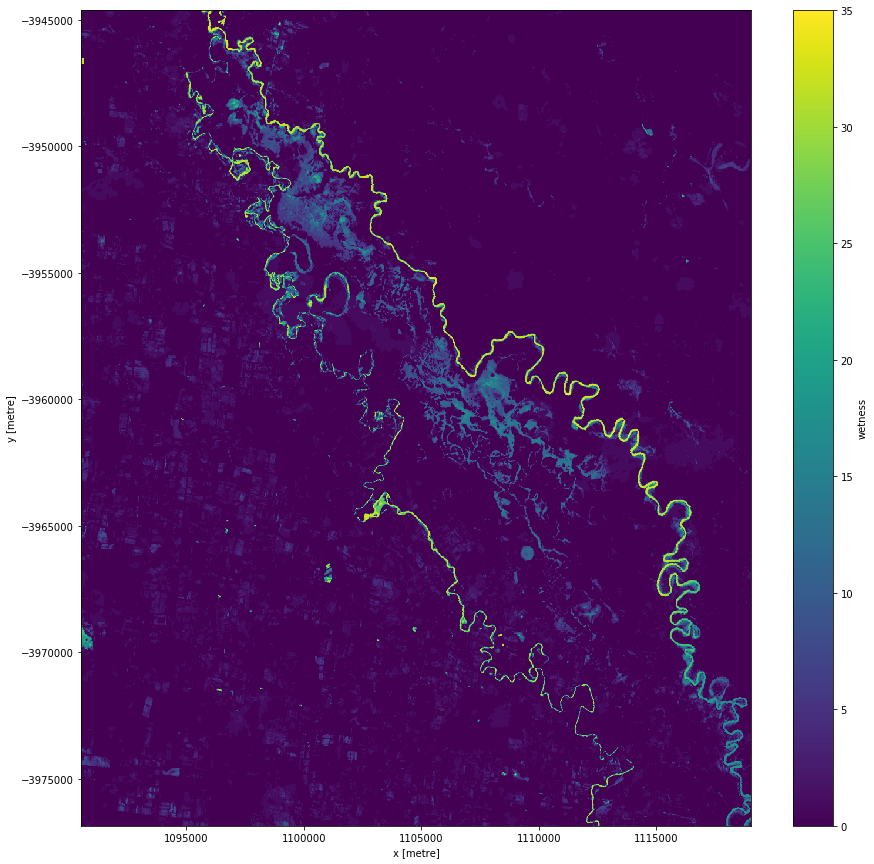

In [30]:
wet_frequency1 = wet_values.sum(dim='time')
wet_frequency1.plot(figsize =(15,15))

In [17]:
#Calulate what number of wetness observations is equal to X% of total observations

precent_threhold = total_obs*0.15
precent_threhold

6.75

In [ ]:
persistant_wet_wet = wet_values

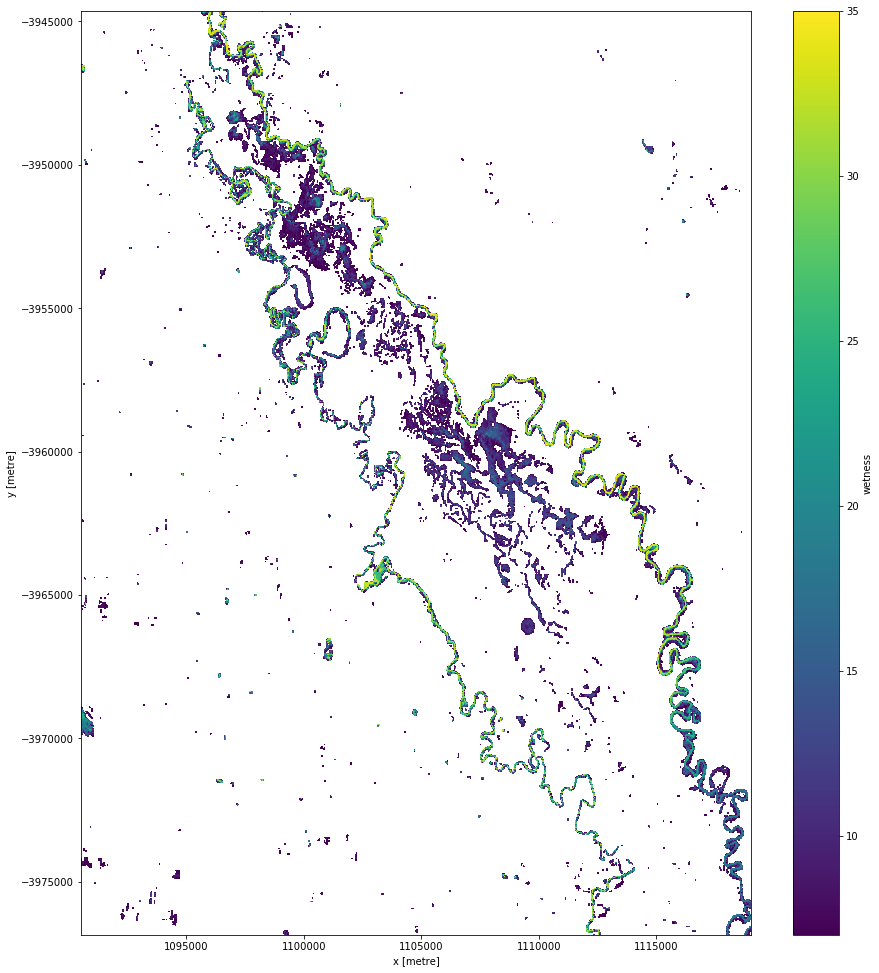

In [31]:

persistant_wet1 = wet_frequency1.where(wet_frequency1>precent_threhold)

persistant_wet1.plot(figsize =(15,17))

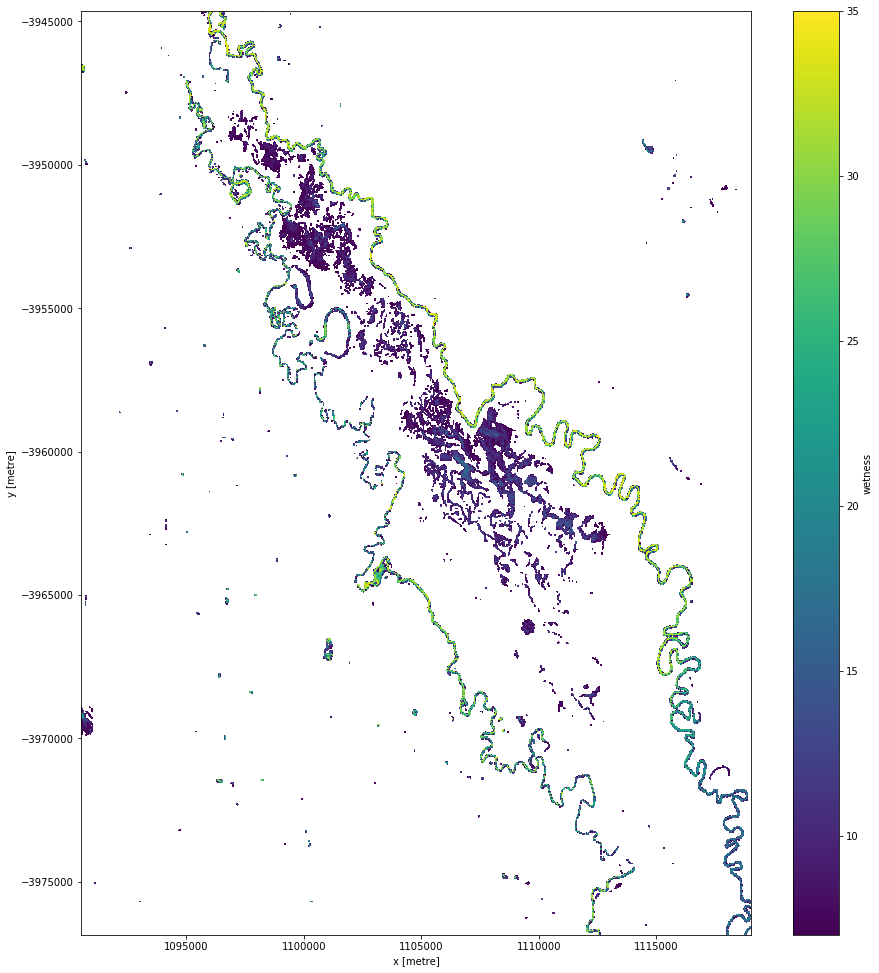

In [18]:
#apply X% threshold to find area inundated for X amount of time

persistant_wet = wet_frequency.where(wet_frequency>precent_threhold)

persistant_wet.plot(figsize =(15,17))

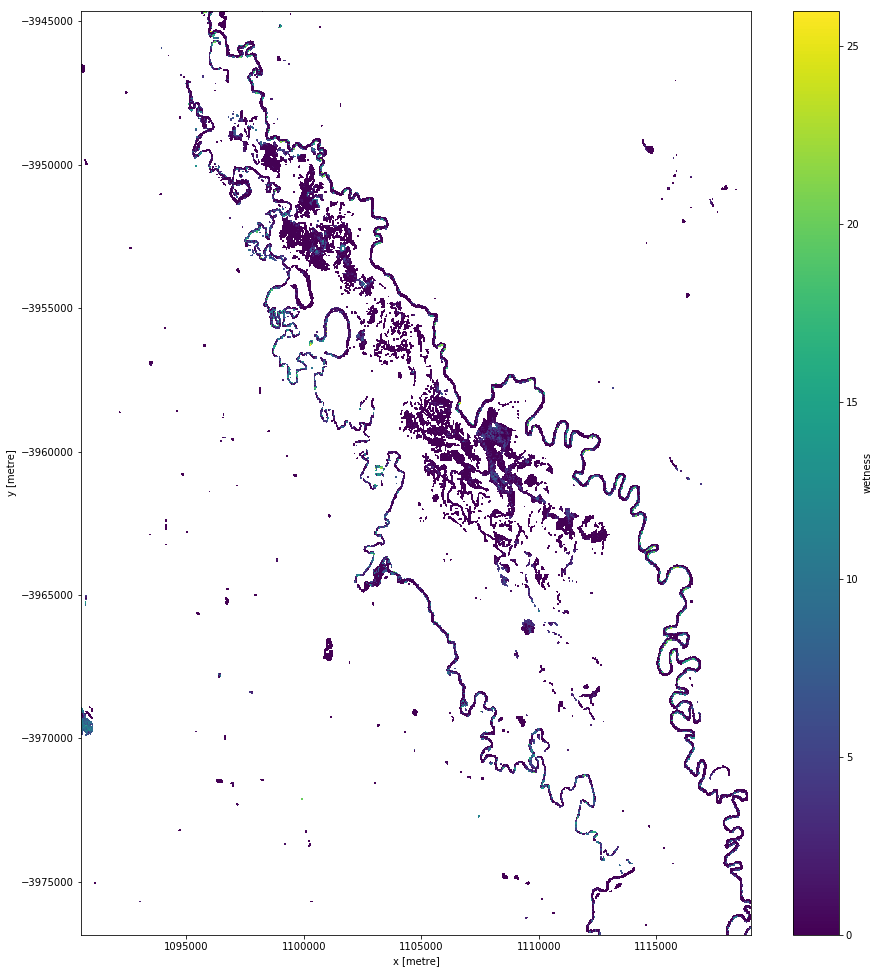

In [33]:
diff_in_methods = persistant_wet1 - persistant_wet

diff_in_methods.plot(figsize =(15,17))

In [19]:

#load wofs filtered summary
wofs_filtered_summary= dc.load(product ='wofs_annual_summary', **query)
wofs_filtered_summary

<xarray.Dataset>
Dimensions:      (time: 1, x: 1140, y: 1289)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-01
  * y            (y) float64 -3.945e+06 -3.945e+06 ... -3.977e+06 -3.977e+06
  * x            (x) float64 1.091e+06 1.091e+06 ... 1.119e+06 1.119e+06
Data variables:
    count_wet    (time, y, x) int16 0 0 0 0 0 0 0 0 0 0 ... 20 4 1 1 0 0 0 0 0 0
    count_clear  (time, y, x) int16 34 33 33 35 34 32 31 ... 23 24 25 25 24 23
    frequency    (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    crs:      EPSG: 3577

In [20]:
wofs_water = wofs_filtered_summary['count_wet']
wofs_water

<xarray.DataArray 'count_wet' (time: 1, y: 1289, x: 1140)>
array([[[0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0],
        ...,
        [0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0]]], dtype=int16)
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01
  * y        (y) float64 -3.945e+06 -3.945e+06 ... -3.977e+06 -3.977e+06
  * x        (x) float64 1.091e+06 1.091e+06 1.091e+06 ... 1.119e+06 1.119e+06
Attributes:
    units:    1
    nodata:   -1
    crs:      EPSG: 3577

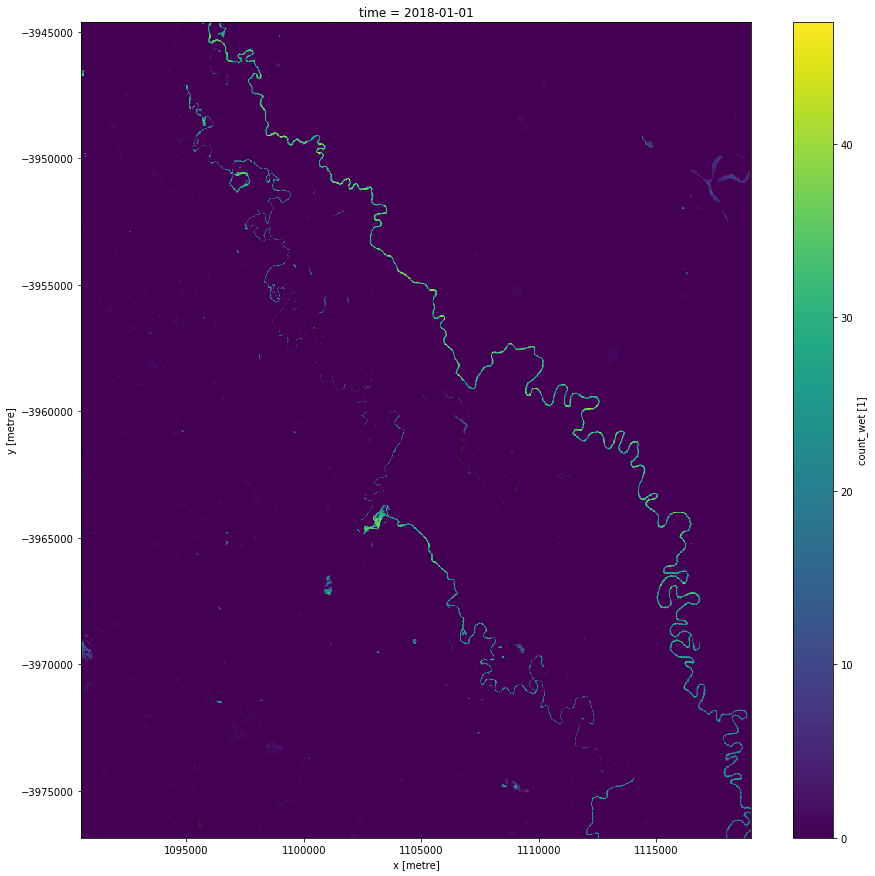

In [21]:
wofs_water.plot(figsize =(15,15))

In [22]:
Inundated_veg = persistant_wet.where(wofs_water<15)

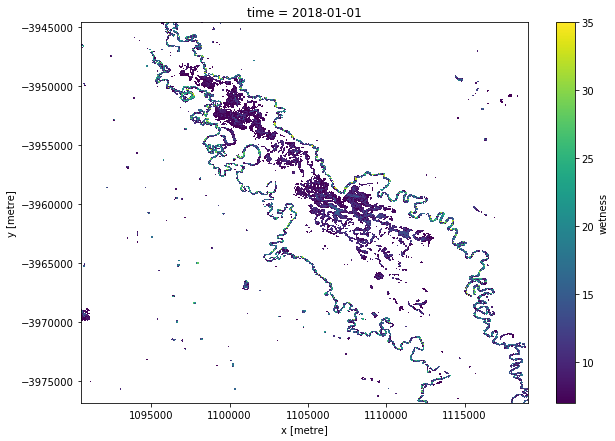

In [23]:
Inundated_veg.plot(figsize =(10,7))

In [25]:
wofs_water['TCW']=Inundated_veg

In [28]:
Inundated_veg

<xarray.DataArray 'wetness' (y: 1289, x: 1140, time: 1)>
array([[[nan],
        [nan],
        ...,
        [nan],
        [nan]],

       [[nan],
        [nan],
        ...,
        [nan],
        [nan]],

       ...,

       [[nan],
        [nan],
        ...,
        [nan],
        [nan]],

       [[nan],
        [nan],
        ...,
        [nan],
        [nan]]])
Coordinates:
  * y        (y) float64 -3.945e+06 -3.945e+06 ... -3.977e+06 -3.977e+06
  * x        (x) float64 1.091e+06 1.091e+06 1.091e+06 ... 1.119e+06 1.119e+06
  * time     (time) datetime64[ns] 2018-01-01

In [ ]:
#save some tassled cap to file
TCT_once = TCI.isel(time=2)
TCT_once

In [29]:
#write_geotiff(filename, dataset, profile_override=None, time_index=None)
#write_geotiff('/g/data/u46/users/ck9738/Datasets/Tasselled_cap_tifs/maquarie_marshes.tif',TCT_once)

AttributeError: 'DataArray' object has no attribute 'crs'